In [ ]:
#Importing Dependcies

import spotipy
import time
from IPython.core.display import clear_output
from spotipy import SpotifyClientCredentials, util
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.simplefilter("ignore")
from flask import request

#Libraries to create the multiclass model
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

#Import tensorflow and disable the v2 behavior and eager mode
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

#Library to validate the model
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
#connection to credentials
from credentials import*


/var/folders/dl/lvr3mtqx0vz098qh46s4bv080000gn/T/ipykernel_10600/5013114.py:5: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output


In [15]:
# Creating csv path and loading first data in Pandas DataFrame

dataMood_df = pd.read_csv("data/data_moods.csv")
dataMood_df.head()

,name,album,artist,id,release_date,popularity,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,mood
0,1999,1999,Prince,2H7PHVdQ3mXqEHXcvclTB0,1982-10-27,68,379266,0.866,0.13700,0.730,0.000000,0.0843,0.625,-8.201,0.0767,118.523,5,4,Happy
1,23,23,Blonde Redhead,4HIwL9ii9CcXpTOTzMq0MP,2007-04-16,43,318800,0.381,0.01890,0.832,0.196000,0.1530,0.166,-5.069,0.0492,120.255,8,4,Sad
2,9 Crimes,9,Damien Rice,5GZEeowhvSieFDiR8fQ2im,2006-11-06,60,217946,0.346,0.91300,0.139,0.000077,0.0934,0.116,-15.326,0.0321,136.168,0,4,Sad
3,99 Luftballons,99 Luftballons,Nena,6HA97v4wEGQ5TUClRM0XLc,1984-08-21,2,233000,0.466,0.08900,0.438,0.000006,0.1130,0.587,-12.858,0.0608,193.100,4,4,Happy
4,A Boy Brushed Red Living In Black And White,They're Only Chasing Safety,Underoath,47IWLfIKOKhFnz1FUEUIkE,2004-01-01,60,268000,0.419,0.00171,0.932,0.000000,0.1370,0.445,-3.604,0.1060,169.881,1,4,Energetic


# Building the model

### Pre-processing the data

In [16]:
# Normalizing the features using MinMaxScaler to scale our values between a range of [0,1]
# we manage to preserve the shape of the original dataset
features = dataMood_df.columns[6:-3]
X= MinMaxScaler().fit_transform(dataMood_df[features])
X2 = np.array(dataMood_df[features])
Y = dataMood_df['mood']

In [20]:
#Encodethe categories
#encoding the 4 categories remembering that the neural network uses numerical values in the tarining and testing processes
encoder = LabelEncoder()
encoder.fit(Y)
encoded_y = encoder.transform(Y)


#Convert to  dummy (Not necessary in my case)
dummy_y = np_utils.to_categorical(encoded_y)

# Splitting  the data by 80% for training and 20% for testing

X_train,X_test,Y_train,Y_test = train_test_split(X,encoded_y,test_size=0.2,random_state=15)

encoded_cat = pd.DataFrame({'mood':dataMood_df['mood'].tolist(),'encode_val':encoded_y}).drop_duplicates().sort_values(['encode_val'],ascending=True)
encoded_cat


,mood,encode_val
5,Calm,0
4,Energetic,1
0,Happy,2
1,Sad,3


In [21]:
 #Create the model

def base_model():
   
    nn_model = Sequential()
    
    #First hidden layer with 8 nodes,input of 4 dim with relu function
    nn_model.add(Dense(units=8,input_dim=10,activation='relu'))
    
    #Second hidden layer with output 3 and softmax function
    nn_model.add(Dense(units=4,activation='softmax'))
    
    #Compile the model using sigmoid loss function and adam optim
    nn_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return nn_model

In [22]:
#Configure the model
estimator = KerasClassifier(build_fn=base_model,epochs=300,verbose=0)

In [23]:
#Evaluate the model using KFold cross validation
# Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample
#commonly used in applied ML to compare and select a model for a given predictive modeling problem because it is easy to understand
#easy to implement and results in skills estimates that generally have a lower bias than others methods
kfold = KFold(n_splits=10,shuffle=True)
results = cross_val_score(estimator,X,encoded_y,cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100,results.std()*100))

Baseline: 80.18% (4.26%)


In [24]:
#Training the model with the train data which represents the 80% of the main data
estimator.fit(X_train,Y_train)

# using the test data to predict the model
y_pred = estimator.predict(X_test)

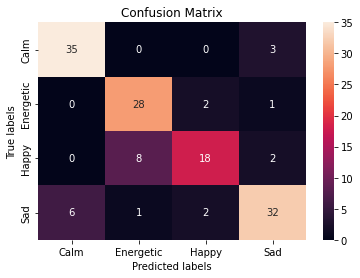

Accuracy Score 0.8188405797101449


<Figure size 432x288 with 0 Axes>

In [25]:
# plotting a confusion matrix to evaluate the accuracy of the model
confx = confusion_matrix(Y_test,y_pred)
ax = plt.subplot()
sns.heatmap(confx,annot=True,ax=ax)

labels =encoded_cat['mood']
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

plt.savefig("image/Confusion_Matrix")

print("Accuracy Score",accuracy_score(Y_test,y_pred))


In [26]:
#credentials field

client_id = "Your Client ID"
client_secret = "Your Client Secret"

In [27]:

#Credentials to access the Spotify Music Data
manager = SpotifyClientCredentials(client_id,client_secret)
sp = spotipy.Spotify(client_credentials_manager=manager)

In [28]:
def access_features(ids):

    metaData = sp.track(ids)
    features = sp.audio_features(ids)

    # meta
    name = metaData['name']
    album = metaData['album']['name']
    artist = metaData['album']['artists'][0]['name']
    release_date = metaData['album']['release_date']
    length = metaData['duration_ms']
    popularity = metaData['popularity']
    ids =  metaData['id']

    # features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    valence = features[0]['valence']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    key = features[0]['key']
    time_signature = features[0]['time_signature']

    song = [name, album, artist, ids, release_date, popularity, length, danceability, acousticness,
            energy, instrumentalness, liveness, valence, loudness, speechiness, tempo, key, time_signature]
    columns = ['name','album','artist','id','release_date','popularity','length','danceability','acousticness','energy','instrumentalness',
                'liveness','valence','loudness','speechiness','tempo','key','time_signature']
    return song,columns

In [29]:
def predict_mood(id_song):
    #Join the model and the MinMaxscaler in a Pipeline
    # The batch size defines the number of samples that will be propagated through the network
    pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,batch_size=200,verbose=0))])
    
    #Fit the Pipeline
    pip.fit(X2,encoded_y)

    #Obtain the features of the song
    pred = access_features(id_song)
    #Pre-process the features to input the Model
    pred_features = np.array(pred[0][6:-2]).reshape(-1,1).T

    #Predict the features of the song
    results = pip.predict(pred_features)

    mood = np.array(encoded_cat['mood'][encoded_cat['encode_val']==int(results)])
    name_song = pred[0][0]
    artist = pred[0][2]

    return print("{0} by {1} is a {2} song".format(name_song,artist,mood[0].upper()))
    

In [31]:
predict_mood('2Vc6NJ9PW9gD9q343XFRKx')